In [2]:
import numpy as np

In [2]:
np.diag(np.arange(1))

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [6]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
np.ones(10) + 0.5

array([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])

In [9]:
np.linalg.inv(np.diag(np.ones(5) + 0.5))

array([[ 0.66666667,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.66666667,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.66666667,  0.        ,  0.        ],
       [-0.        , -0.        , -0.        ,  0.66666667, -0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.66666667]])

In [7]:
x = np.array([[10,2],[3,4]])

In [4]:
mask = np.random.choice([0,1], size=x.shape, p=[0.75, 0.25])

In [5]:
mask

array([[1, 0],
       [0, 0]])

In [8]:
np.multiply(mask, x)

array([[10,  0],
       [ 0,  0]])

# 1. Operators

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools.projectB as im
%matplotlib notebook

In [17]:
x0 = plt.imread('assets/starfish.png')
i = im.Identity(x0.shape)
v = im.kernel('motion')
c = im.Convolution(x0.shape, v)
r = im.RandomMasking(x0.shape, 0.4)

<IPython.core.display.Javascript object>


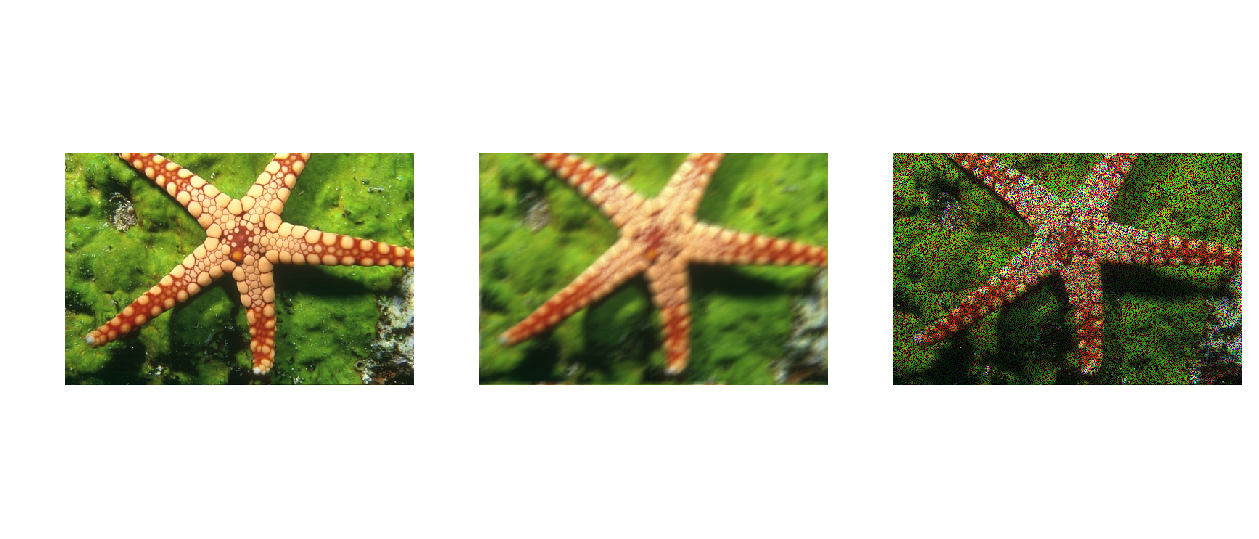

In [42]:
xI = i(x0)
xC = c(x0)
xR = r(x0)

fig, axes = plt.subplots(ncols=3, figsize=(7,3))
im.show(xI, ax=axes[0])
im.show(xC, ax=axes[1])
im.show(xR, ax=axes[2])
fig.show()

In [3]:
y = plt.imread('assets/flowers.png')

In [4]:
g = im.Grad(y.shape)

ValueError: setting an array element with a sequence.

# 2. Smoothed Total-Variation

### 7. Why does TV promote piece-wise constant solutions?

TV promotes piece-wise constant solutions due to the nature that TV smooths out large ‘flat’ regions in the image by only storing the gradient of the image to do so.   This is since the loss function, which is the gradient of x, is simply comparing the difference between a pixel and its neighbors, thus only detecting edges in the image.  Since there are relatively few edges in relation to image size, this leads TV to produce piece-wise constant solutions.  


### 8. Proving the gradient of the energy function

In [ ]:
1.  Given: E(x) = 1/2 * l2_norm(y-Hx)^2 + tau * l1_norm(grad(x))
2.  Substitute grad(x) with the approximation sqrt(abs(grad(x))^2 + e)
3.  Differentiate both terms of the sum.
4.  d/dx (1/2 * l2_norm(y-Hx)^2) = -H* * (y-Hx) = H*(Hx-y)
5.  d/dx (tau * l1_norm(sqrt(abs(grad(x))^2 + e)))) = tau * grad(sqrt(abs(grad(x))^2 + e))
6.  Chain Rule: tau * grad(sqrt(abs(grad(x))^2 + e)) = tau * grad(grad(x) / sqrt(abs(grad(x))^2 + e)
7.  Def. of Divergence  tau * grad(grad(x) / sqrt(abs(grad(x))^2 + e) = -tau * div(grad(x) / sqrt(abs(grad(x))^2 + e)
8.  Combine both terms of sum to get grad(E(x)) as H*(Hx-y) - tau * div(grad(x) / sqrt(abs(grad(x))^2 + e)

In [3]:
x =  plt.imread('assets/starfish.png')
sig = 20 / 255
y = x + sig * np.random.randn(*x.shape)

### 9. Total Variation: Gradient Descent

In [ ]:
def total_variation(y,sig,H=None, m=400, scheme='gd', rho=1, return_energy=False):
    tau = rho * sig
    epsilon = sig**2 * 0.001
    if H is None:
        H = Identity(y.shape)
        
    laplacian = kernel('laplacian2')
    L = H.norm2()**2 + (tau/np.sqrt(epsilon)) * np.sqrt(np.sum(laplacian ** 2))
    gamma = 1 / L
    
    
    def energy(H, x, y, tau):
        op1 = 0.5 * np.sum((y-H(x))** 2)
        op2 = tau * np.sum(np.gradient(x))
        return op1 + op2
    
    def loss(H, x, y, tau, epsilon):
        op1 = H.gram(x) - H.adjoint(y)
        gradX = grad(x)
        op2 = tau * np.sum((gradX / np.sqrt(np.abs(gradX)**2 + epsilon)), axis=2)
        return op1 - op2
    
    x = H.adjoint(y)
    
    if scheme is 'gd':
        if return_energy:
            e = []        
            for i in range(m):
                e.append(energy(H,x,y,tau))
                x = x - gamma * loss(H,x,y,tau,epsilon)              
            return x, e

        else:
            for i in range(m):
                print("iteration %d"% i)
                x = x - gamma * loss(H,x,y,tau,epsilon)
            return x

### 10. Total Variation: Gradient Descent Using Nesterov Acceleration

In [ ]:
def total_variation(y,sig,H=None, m=400, scheme='gd', rho=1, return_energy=False):
    ...
    elif scheme is 'nesterov':        
        xBar = H.adjoint(y)
        prevX = x
        
        def calcT1(t):
            return (1 + np.sqrt(1 + 4*t**2)) / 2
        
        def calcU(t, t1):
            return (t-1)/t1
        
        t = 1
        t1 = calcT1(t)
        
        if return_energy:
            e = []
            for i in range(m):
                e.append(energy(H,x,y,tau))
                prevX = x
                x = xBar - gamma * loss(H,xBar,y,tau,epsilon)
                xBar = x + calcU(t,t1)*(x-prevX)          
                t = t1
                t1 = calcT1(t)
            return x, e
        
        else:
            for i in range(m):
                print("iteration %d"% i)
                prevX = x
                x = xBar - gamma * loss(H,xBar,y,tau,epsilon)
                xBar = x + calcU(t,t1)*(x-prevX)          
                t = t1
                t1 = calcT1(t)
            return x

In [8]:
xHat = im.total_variation(y, sig, m=50)
xHatNest = im.total_variation(y, sig, m=50, scheme='nesterov')

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49


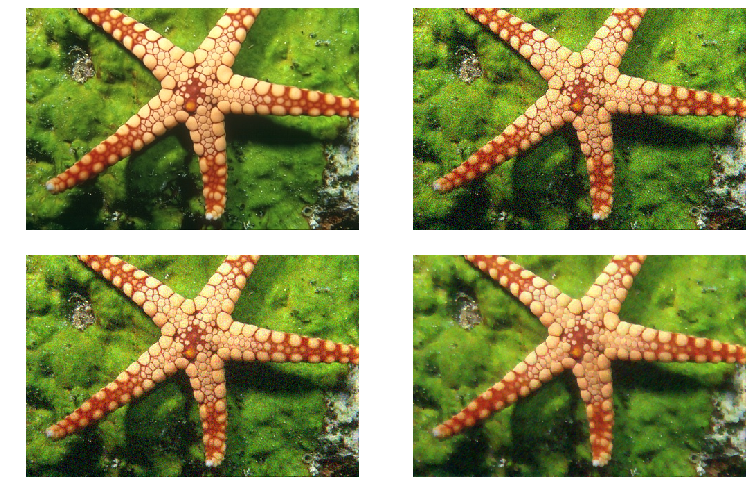

In [20]:
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(12,7))
im.show(x, ax[0][0])
im.show(y, ax[0][1])
im.show(xHat, ax[1][0])
im.show(xHatNest, ax[1][1])
fig.show()

# 3. Advanced Solvers for Total-Variation

### 14. SoftThresh

In [33]:
def softthresh(z, t):
    z[np.abs(z) <= t] = 0
    return z - np.sign(z)*t

In [34]:
x = np.array([-20,-10,-5,0,5,10,20])
softthresh(x, 5)

array([-15,  -5,   0,   0,   0,   5,  15])

In [74]:
x = plt.imread('assets/starfish.png')
xHatADMM = im.total_variation(y, sig, m=50, scheme='admm')

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49


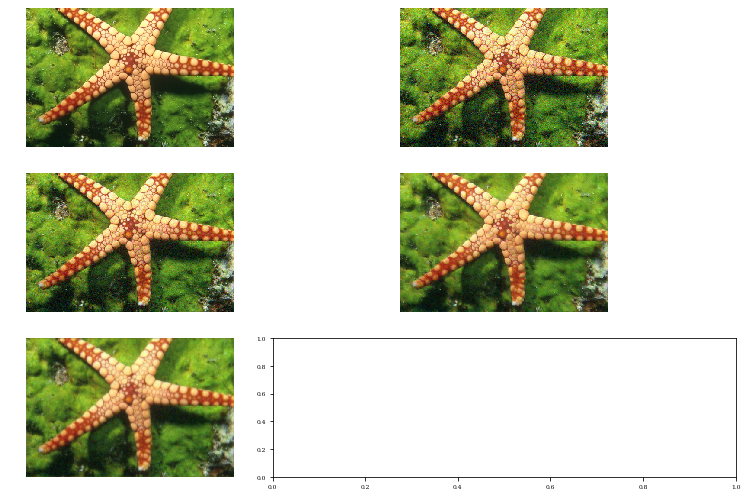

In [75]:
fig,ax = plt.subplots(nrows=3, ncols=2, figsize=(12,7))
im.show(x, ax[0][0])
im.show(y, ax[0][1])
im.show(xHat, ax[1][0])
im.show(xHatNest, ax[1][1])
im.show(xHatADMM, ax[2][0])
fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


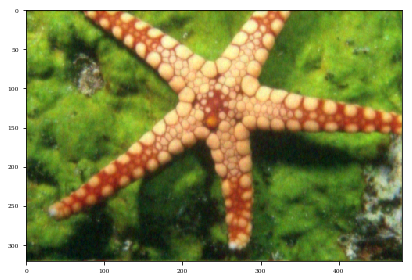

In [76]:
plt.imshow(xHatADMM)

In [67]:
gamma = 1
G = im.Grad(y.shape)
xBar = H.adjoint(y)
zBar = G(xBar)
dX = np.zeros(xBar.shape)
dZ = np.zeros(zBar.shape)
x = None
z = None
tau = sig
H = im.Identity(y.shape)

x = H.gram_resolvent(xBar, gamma) + H.gram_resolvent(dX, gamma) + H.gram_resolvent(gamma * H.adjoint(y), gamma)
z = softthresh(zBar + dZ, gamma*tau)
xBar = G.gram_resolvent(x, 1) - G.gram_resolvent(dX, 1) + G.gram_resolvent(G.adjoint(np.sum(z-dZ, axis=2)),1)
zBar = G(xBar)
dX = dX - x + xBar
dZ = dZ - z + zBar

In [69]:
z.shape

(321, 481, 2, 3)

In [70]:
dZ.shape

(321, 481, 2, 3)

In [72]:
np.sum(z-dZ, axis=2).shape

(321, 481, 3)

In [73]:
G.gram_resolvent(dX,1).shape

(321, 481, 3)